In [44]:
# imports
import torch
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

from models.pibnn_v2 import PIBNNV2
from helper.evaluator import Evaluator
from helper.trajectory import Trajectory
from models.stonesoup_radar_sim import StonesoupRadarSim
from mpl_toolkits.mplot3d import Axes3D

In [63]:
def construct_train_test_split(full_proc_traj_data_in, train_percent=0.8, random_state=80):
    """
    Splits the trajectory dictionary into training and testing sets while extracting and concatenating
    specific fields from each trajectory.

    Parameters:
    - full_proc_traj_data_in (dict): Dictionary containing trajectory data.
    - train_percent (float): The proportion of data to use for training (default 0.8).
    - random_state (int, optional): Random seed for reproducibility.

    Returns:
    - train_X_mats (list of torch.Tensor): Training input matrices.
    - train_y_vecs (list of torch.Tensor): Training output vectors.
    - test_X_mats (list of torch.Tensor): Testing input matrices.
    - test_y_vecs (list of torch.Tensor): Testing output vectors.
    - physics_metadata_train_dicts (list of dict): Physics metadata for training.
    - physics_metadata_test_dicts (list of dict): Physics metadata for testing.
    """
    np.random.seed(random_state)
    keys = list(full_proc_traj_data_in.keys())
    np.random.shuffle(keys)

    split_idx = int(len(keys) * train_percent)
    _train_keys, _test_keys = keys[:split_idx], keys[split_idx:]

    _train_pmd_dict = {
        'inputPos': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputPos'] for key in _train_keys], dim=0),
        'inputVel': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputVel'] for key in _train_keys], dim=0),
        'inputObs': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputObs'] for key in _train_keys], dim=0),
        'inputRngErr': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputRngErr'] for key in _train_keys], dim=0),
        'dtVec': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['dtVec'] for key in _train_keys], dim=0)
    }
    _train_X_mat = torch.cat([full_proc_traj_data_in[key]['X_mat'] for key in _train_keys], dim=0)
    _train_y_vec = torch.cat([full_proc_traj_data_in[key]['y_vec'] for key in _train_keys], dim=0)

    _test_pmd_dict = {
        'inputPos': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputPos'] for key in _test_keys], dim=0),
        'inputVel': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputVel'] for key in _test_keys], dim=0),
        'inputObs': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputObs'] for key in _test_keys], dim=0),
        'inputRngErr': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputRngErr'] for key in _test_keys], dim=0),
        'dtVec': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['dtVec'] for key in _test_keys], dim=0)
    }
    _test_X_mat = torch.cat([full_proc_traj_data_in[key]['X_mat'] for key in _test_keys], dim=0)
    _test_y_vec = torch.cat([full_proc_traj_data_in[key]['y_vec'] for key in _test_keys], dim=0)

    return _train_X_mat, _train_y_vec, _test_X_mat, _test_y_vec, _train_pmd_dict, _test_pmd_dict, _train_keys, _test_keys

In [64]:
def evaluate_model_outputs(y_pred_state, y_pred_covariances, y_truth_state):
    TestEval = Evaluator()
    full_pred_pos = y_pred_state[:, 0:3]
    full_truth_pos = y_truth_state[:, 0:3].cpu().numpy()
    
    proc_covariances = []    
    for idx, cov_vec in enumerate(y_pred_covariances):
        proc_covariances.append(y_pred_covariances[idx, 0:3, 0:3])
        
    avg_err = TestEval.calculate_3d_avg_euclid_error(full_truth_pos[:, 0], full_truth_pos[:, 1], full_truth_pos[:, 2], full_pred_pos[:, 0], full_pred_pos[:, 1], full_pred_pos[:, 2])
    avg_md = TestEval.average_mahalanobis_distance(full_pred_pos, proc_covariances, full_truth_pos) 
    avg_det = TestEval.compute_average_determinant(proc_covariances)
    avg_trace = TestEval.compute_average_covariance_trace(proc_covariances)
    return avg_err, avg_md, avg_trace, avg_det

In [65]:
# DEVELOP SOME SORT OF BINARY COUNTER FOR "CONTAINMENT"


# Mid Noise Level

In [66]:
sensor_noise_level = 'mid'
epochs = 1000 # KEEP TO 1000
lambda_params_in = {'ml': 0.7, 'physics': 0.3}

In [67]:
# TRAIN BNN on 80% and EVAL ON 20%. STORE EVAL POS AND COV FOR EVERY TEST TRAJ POINT
aug_path_in = f"../../dataset/dataframe-readins/cv/augmented/full_traj_data_proc_noise_{sensor_noise_level}.pkl"
           
if os.path.exists(aug_path_in):
    with open(aug_path_in, "rb") as e:
        aug_proc_traj_data = pickle.load(e)
        
train_X_mat, train_y_vec, test_X_mat, test_y_vec, train_pmd_dict, test_pmd_dict, train_keys, test_keys = construct_train_test_split(aug_proc_traj_data, train_percent=0.8, random_state=80)

## BNN EVAL

In [68]:
print(train_X_mat.shape)
print(train_y_vec.shape)
print(test_X_mat.shape)
print(test_y_vec.shape)

torch.Size([1385435, 17])
torch.Size([1385435, 6])
torch.Size([349271, 17])
torch.Size([349271, 6])


In [69]:
%%time
bnn_model = PIBNNV2(input_size=train_X_mat.shape[1], output_size=train_y_vec.shape[1], hidden_layer_size=64, sensor_noise_level=sensor_noise_level,
             prior_sigma_lay=0.01, lambda_params=lambda_params_in, epochs=epochs, bias_in=True)

bnn_model.fit(train_X_mat, train_y_vec, train_pmd_dict)

nn_state_est_vecs, nn_state_cov_mats = bnn_model.predict(test_X_mat, test_pmd_dict['inputObs'], test_pmd_dict['inputRngErr'], apply_filter_update=True)

bnn_model.save_model_weights(file_prefix=f"{epochs}_64H_{sensor_noise_level}", directory="../../models/saved_weights/pibnn")

 Epoch: 1000/1000 | Loss:  11.94 

Model weights saved to ../../models/saved_weights/pibnn\1000_64H_mid_pibnn_model_2025-03-09_20-04-40.pth
CPU times: total: 3h 40min 31s
Wall time: 28min 11s


'../../models/saved_weights/pibnn\\1000_64H_mid_pibnn_model_2025-03-09_20-04-40.pth'

In [71]:
%%time
## print evaluation
ed, md, trace, det = evaluate_model_outputs(nn_state_est_vecs, nn_state_cov_mats, test_y_vec)

print(f"ED: {ed}")
print(f"MD: {md}")
print(f"TRACE: {trace}")
print(f"DETERMINANT: {det}")

ED: 6.7739598686208735
MD: 9.258745637257494
TRACE: 2.6844017818736043
DETERMINANT: 1.5784761465565704
CPU times: total: 5.94 s
Wall time: 6.11 s


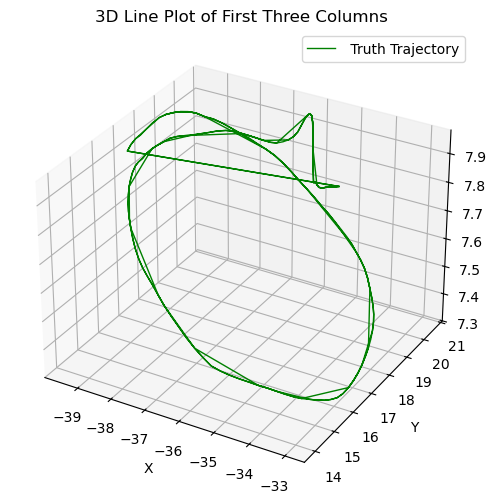

In [41]:
# PLOT RANDOM TEST TRAJ TRUTH GIF + BNN PRED/COV CONTAINMENT
traj_no = 16
truth_data = aug_proc_traj_data[test_keys[traj_no]]['y_vec']
xyz = truth_data[:, :3].numpy()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2], color='g', linewidth=1.0, label=" Truth Trajectory")
# TODO -> HOW DO I KNOW THE CORRESPONDING PREDICTIONS FROM THE NN OUTPUT
# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Line Plot of First Three Columns")
ax.legend()
plt.show()

## EVAL EVAL

In [74]:
def run_stonesoup_ekf_eval_pipeline(aTrajectory, aSim, anEvaluator, ifplot=False, ifshow=False, moe=False):
    test_radar_meas = aSim.simulate_radar_measurements(aTrajectory)
    filter_tracks_list = aSim.run_ekf_filter(aTrajectory, test_radar_meas)
    
    converted_state_vecs, measurement_conversion_data = aSim.convert_radar_observations_to_cartesian(test_radar_meas)
    aTrajectory.set_converted_measurement_data(measurement_conversion_data)

    predicted_state_data, predicted_uncer_std_data = aSim.process_stonesoup_tracker_info(filter_tracks_list)
    full_pos_states, full_pos_covs = aSim.gather_position_prediction_info(filter_tracks_list) # for numerical eval
    
    if ifplot:
        aTrajectory.visualize_truth_versus_measurement()
        aTrajectory.visualize_truth_versus_filter(predicted_state_data, predicted_uncer_std_data)
        
    outData = {}
    pred_data = {}
    if moe:
        full_truth_pos = np.column_stack((aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], predicted_state_data['x'], predicted_state_data['y'], predicted_state_data['z'])
    else:
        full_truth_pos = np.column_stack((aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:], predicted_state_data['x'],predicted_state_data['y'], predicted_state_data['z'])
    
    
    outData['MeasErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], measurement_conversion_data['x'][1:], measurement_conversion_data['y'][1:], measurement_conversion_data['z'][1:])
    outData['MDAvg'] = anEvaluator.average_mahalanobis_distance(full_pos_states, full_pos_covs, full_truth_pos)
    outData['DeterminantAvg'] = anEvaluator.compute_average_determinant(full_pos_covs)
    outData['TraceAvg'] = anEvaluator.compute_average_covariance_trace(full_pos_covs)
    
    pred_data['States'] = full_pos_states
    pred_data['Covariances'] = full_pos_covs
    pred_data["Truth"] = full_truth_pos
    
    if ifshow:
        print(f"Average Filter Error: {outData['PredErrAvg']}")
        print(f"Average Measurement Error: {outData['MeasErrAvg']}")
        print(f"Average Filter Trace: {outData['TraceAvg']}")
        print(f"Average Filter MD: {outData['MDAvg']}")
        print(f"Average Filter Determinant: {outData['DeterminantAvg']}")
    return outData, aTrajectory, pred_data

In [76]:
def eval_batch_ekf(aTrajDict, aTestSim, aSample_rmv_percent=0, moe=False):
    aTestEval = Evaluator()
    filter_mds = []
    filter_errs = []
    filter_traces = []
    filter_dets = []
    meas_errs = []
    traj_state_data = {}
    for traj_no_idx, traj_df in aTrajDict.items():
        temp_truth_data = store_truth_data(traj_df)
        temp_traj = Trajectory(temp_truth_data, traj_no_idx, measurement_only_eval=moe)
        temp_traj.apply_sampling_gaps(remove_pct=aSample_rmv_percent)
        pipe_out, none, state_data = run_stonesoup_ekf_eval_pipeline(temp_traj, aTestSim, aTestEval, ifplot=False, ifshow=False, moe=moe)
        
        traj_state_data[traj_no_idx] = state_data
        filter_errs.append(pipe_out['PredErrAvg'])
        filter_traces.append(pipe_out['TraceAvg'])
        filter_mds.append(pipe_out['MDAvg'])
        filter_dets.append(pipe_out['DeterminantAvg'])
        meas_errs.append(pipe_out['MeasErrAvg'])
        
    return np.mean(filter_errs), np.mean(filter_traces), np.mean(filter_mds), np.mean(meas_errs), np.mean(filter_dets), traj_state_data

In [77]:
def store_truth_data(aDF):
    return {'timestamps': np.array(aDF['timestamp']), 
              'x': np.array(aDF['tx']), 
              'y': np.array(aDF['ty']),
              'z': np.array(aDF['tz']), 
              'vx': np.array(aDF['vx']), 
              'vy': np.array(aDF['vy']),
              'vz': np.array(aDF['vz'])}

In [78]:
include_rr = True
sample_rmv_percents = [0, 25, 50]

path = "../../dataset/dataframe-readins/full_traj_data.pkl"
with open(path, "rb") as b:
    full_traj_dict = pickle.load(b)

test_dict = {key: full_traj_dict[key] for key in test_keys if key in full_traj_dict}

In [79]:
%%time
# RUN EKF ON ALL TEST TRAJ AND STORE PRED POS AND COV FOR EVERY TRAJ POINT
test_sim = StonesoupRadarSim(sensor_noise_level=sensor_noise_level, include_range_rate=include_rr)
cv_filter_errs, cv_filter_traces, cv_filter_mds, cv_meas_errs, cv_filter_dets = [], [], [], [], []
varying_sample_rmv_preds = []
for percent in sample_rmv_percents:
    mean_ferr, mean_trace, mean_md, mean_merr, mean_det, traj_state_data = eval_batch_ekf(test_dict, test_sim, aSample_rmv_percent=percent, moe=True)
    cv_filter_errs.append(mean_ferr)
    cv_filter_traces.append(mean_trace)
    cv_filter_dets.append(mean_det)
    cv_filter_mds.append(mean_md)
    cv_meas_errs.append(mean_merr)
    varying_sample_rmv_preds.append(traj_state_data)
    
print(f"NOISE LEVEL: {sensor_noise_level.upper()}")

print(f"Average Filter Err: {np.mean(cv_filter_errs)}")
print(f"Average Filter Trace: {np.mean(cv_filter_traces)}")
print(f"Average Filter MD: {np.mean(cv_filter_mds)}")
print(f"Average Filter Det: {np.mean(cv_filter_dets)}")
print(f"Average Meas Err [DEBUG]: {np.mean(cv_meas_errs)}")

NOISE LEVEL: MID
Average Filter Err: 5.511555360419751
Average Filter Trace: 3.25488652037766
Average Filter MD: 10.266283785610785
Average Filter Det: 0.013626201974100144
Average Meas Err [DEBUG]: 9.423892946834647
CPU times: total: 6min 54s
Wall time: 6min 56s


In [108]:
from scipy.spatial.transform import Rotation as R

# Function to plot a single covariance ellipsoid
def plot_ellipsoid(ax, mean, cov, color='r', alpha=0.005):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Create ellipsoid surface
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 10)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    xyz = np.stack((x, y, z), axis=-1)

    # Scale by eigenvalues (axes lengths)
    scaling = np.sqrt(eigenvalues)  # Standard deviation scaling
    xyz *= scaling

    # Rotate using eigenvectors
    xyz = xyz @ eigenvectors.T

    # Translate to mean position
    x, y, z = xyz[..., 0] + mean[0], xyz[..., 1] + mean[1], xyz[..., 2] + mean[2]

    # Plot surface
    ax.plot_wireframe(x, y, z, color=color, alpha=alpha)


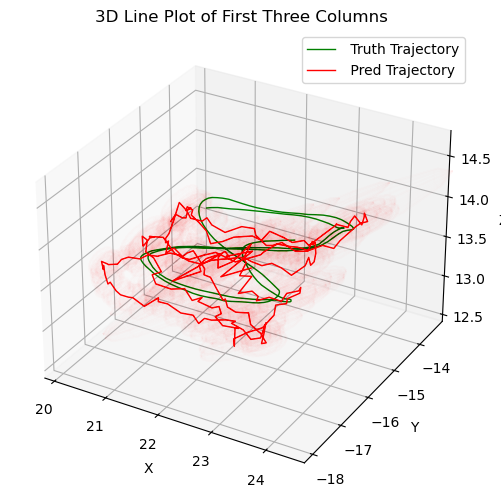

In [111]:
# STATIC
sample_no = 501
base = varying_sample_rmv_preds[0]
truth = base[sample_no]['Truth']
pred_states = np.array(base[sample_no]['States'])
pred_covariances = np.array(base[sample_no]['Covariances'])

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(truth[:, 0], truth[:, 1], truth[:, 2], color='g', linewidth=1.0, label=" Truth Trajectory")
ax.plot(pred_states[:, 0], pred_states[:, 1], pred_states[:, 2], color='r', linewidth=1.0, label=" Pred Trajectory")

for i in range(len(pred_states)):
    plot_ellipsoid(ax, pred_states[i, :], pred_covariances[i, :, :])


# Labels and title
ax.set_xlim(truth[:, 0].min() - 1, truth[:, 0].max() + 1)
ax.set_ylim(truth[:, 1].min() - 1, truth[:, 1].max() + 1)
ax.set_zlim(truth[:, 2].min() - 1, truth[:, 2].max() + 1)

ax.autoscale_view()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Line Plot of First Three Columns")
ax.legend()
plt.show()

Error in callback <function _draw_all_if_interactive at 0x0000012E3FF1D9E0> (for post_execute), with arguments args (),kwargs {}:


TypeError: Value after * must be an iterable, not Line3DCollection

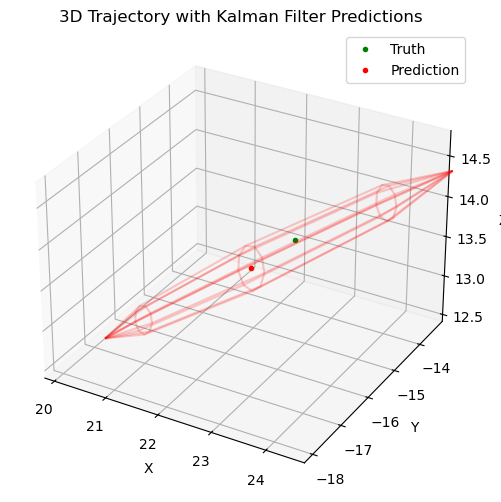

In [113]:
# # GIF PLOT
# 
# from matplotlib.animation import FuncAnimation, PillowWriter
# 
# # Sample data setup
# sample_no = 501
# base = varying_sample_rmv_preds[0]  # Your stored predictions
# truth = np.array(base[sample_no]['Truth'])  # (N,3) ground truth
# pred_states = np.array(base[sample_no]['States'])  # (N,3) predictions
# pred_covariances = np.array(base[sample_no]['Covariances'])  # (N,3,3) covariances
# 
# num_frames = len(pred_states)
# 
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# 
# truth_plot, = ax.plot([], [], [], 'go', markersize=3, label="Truth")
# pred_plot, = ax.plot([], [], [], 'ro', markersize=3, label="Prediction")
# ellipsoid_plots = [] 
# 
# 
# def plot_ellipsoid(ax, mean, cov, color='r', alpha=0.2):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     
#     u = np.linspace(0, 2 * np.pi, 10)
#     v = np.linspace(0, np.pi, 5)
#     x = np.outer(np.cos(u), np.sin(v))
#     y = np.outer(np.sin(u), np.sin(v))
#     z = np.outer(np.ones_like(u), np.cos(v))
#     xyz = np.stack((x, y, z), axis=-1)
# 
#     scaling = np.sqrt(eigenvalues)
#     xyz *= scaling
#     xyz = xyz @ eigenvectors.T
# 
#     x, y, z = xyz[..., 0] + mean[0], xyz[..., 1] + mean[1], xyz[..., 2] + mean[2]
#     return ax.plot_wireframe(x, y, z, color=color, alpha=alpha)
# 
# 
# def update(frame):
#     global ellipsoid_plots
# 
#     truth_plot.set_data(truth[:frame+1, 0], truth[:frame+1, 1])
#     truth_plot.set_3d_properties(truth[:frame+1, 2])
# 
#     pred_plot.set_data(pred_states[:frame+1, 0], pred_states[:frame+1, 1])
#     pred_plot.set_3d_properties(pred_states[:frame+1, 2])
# 
#     for eplot in ellipsoid_plots:
#         eplot.remove()
#     ellipsoid_plots = []
# 
#     ellipsoid_plots = plot_ellipsoid(ax, pred_states[frame], pred_covariances[frame])
#     
#     return truth_plot, pred_plot, *ellipsoid_plots
# 
# # Set plot limits
# ax.set_xlim(truth[:, 0].min() - 1, truth[:, 0].max() + 1)
# ax.set_ylim(truth[:, 1].min() - 1, truth[:, 1].max() + 1)
# ax.set_zlim(truth[:, 2].min() - 1, truth[:, 2].max() + 1)
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.set_title("3D Trajectory with Kalman Filter Predictions")
# ax.legend()
# 
# # Create the animation
# ani = FuncAnimation(fig, update, frames=num_frames, interval=100, blit=False)
# 
# # # Save as GIF
# # ani.save(f"../../dataset/GIFS/trajectory_no_{sample_no}_animation.gif", writer=PillowWriter(fps=10))
# # 
# # plt.show()
